In [24]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics

In [25]:
def convert_to_float(n):
  try:
    return float(n)
  except ValueError:
    return None
  
def removeOutliers(x, outlierConstant=1):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

**Get data from google drive**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data_path = Path('drive/MyDrive/UMwPL_projekt')
KlekFP_preprocessed = Path('drive/MyDrive/UMwPL_projekt/KlekFP_preprocessed.csv')
ExtFP_set_path = data_path.joinpath('cardiotoxicity_hERG_ExtFP_ready_set.csv')
KlekFP_set_path = data_path.joinpath('cardiotoxicity_hERG_KlekFP_ready_set.csv')
MACCSFP_set_path = data_path.joinpath('cardiotoxicity_hERG_MACCSFP_ready_set.csv')
results_path = data_path.joinpath('results')

In [29]:
df = pd.read_csv(KlekFP_set_path, header=0, index_col=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
print(df)

           IC50  KRFP1  KRFP2  KRFP3  ...  KRFP4857  KRFP4858  KRFP4859  KRFP4860
0         645.0      0      0      0  ...         0         0         0         0
1        6600.0      0      0      0  ...         0         0         0         0
2        1600.0      0      0      0  ...         0         0         0         0
3        6700.0      0      0      0  ...         0         0         0         0
4        6600.0      0      0      0  ...         0         0         0         0
...         ...    ...    ...    ...  ...       ...       ...       ...       ...
11499    6600.0      1      1      0  ...         0         0         0         0
11500  100000.0      1      1      0  ...         0         0         0         0
11501   30000.0      1      1      0  ...         0         0         0         0
11502   26000.0      1      0      0  ...         0         0         0         0
11503       1.7      1      0      0  ...         0         0         0         0

[11504 rows x 4

**Data Preprocessing**

In [30]:
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
print(f"Number of columns: {len(nunique)} \nRemoved Columns: {len(cols_to_drop)}")
df = df.drop(cols_to_drop, axis=1)
print(f"Number of columns after removal: {len(df.nunique())}")

Number of columns: 4861 
Removed Columns: 2722
Number of columns after removal: 2139


In [31]:
df["IC50"] = df["IC50"].apply(convert_to_float)
df = df.dropna()
df.loc[1:] = df.loc[1:].astype('int')
len(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


10635

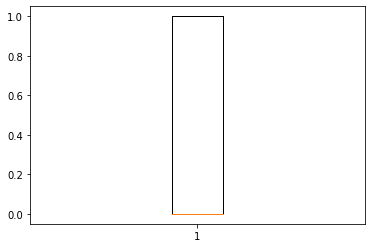

In [36]:
plt.boxplot(removeOutliers(df["IC50"]))
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


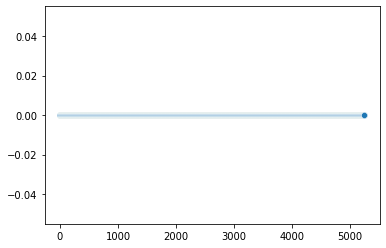

In [35]:
tmp = np.sort(-np.log10(df["IC50"]))
sns.scatterplot(data=tmp)

In [34]:
df['IC50'] = df['IC50'].apply(lambda x: 1 if x < 10000 else 0)

In [37]:
df["IC50"].value_counts()

0    5389
1    5246
Name: IC50, dtype: int64

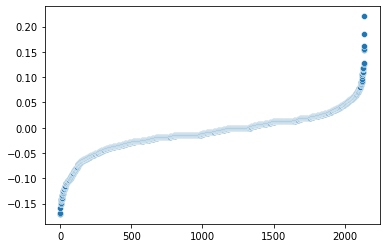

In [38]:
d = df
n_nontoxic0 = (d.groupby(['IC50']).count() - d.groupby(['IC50']).sum()).loc[0]
n_toxic0 = (d.groupby(['IC50']).count() - d.groupby(['IC50']).sum()).loc[1]
n_nontoxic1 = d.groupby(['IC50']).sum().loc[0]
n_toxic1 = d.groupby(['IC50']).sum().loc[1]


phi = ((n_toxic0 * n_toxic1) - (n_toxic0 * n_nontoxic1)) / np.sqrt((n_toxic1+n_toxic0) * (n_toxic1 + n_nontoxic1) * (n_nontoxic1 + n_nontoxic0) * (n_toxic0) + n_nontoxic0)
sns.scatterplot(data=np.sort(phi))

In [43]:
# df_less_features = df.drop(columns=phi.where(phi.between(-0.02, 0.02)).dropna().index)

In [41]:
df

,IC50,KRFP1,KRFP2,KRFP3,KRFP7,KRFP8,KRFP10,KRFP13,KRFP14,KRFP15,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,KRFP21,KRFP23,KRFP25,KRFP26,KRFP27,KRFP33,KRFP34,KRFP35,KRFP36,KRFP37,KRFP38,KRFP40,KRFP41,KRFP42,KRFP44,KRFP45,KRFP46,KRFP47,KRFP48,KRFP49,KRFP51,KRFP52,KRFP53,KRFP54,KRFP55,...,KRFP4772,KRFP4774,KRFP4778,KRFP4780,KRFP4803,KRFP4805,KRFP4806,KRFP4808,KRFP4810,KRFP4811,KRFP4812,KRFP4813,KRFP4815,KRFP4818,KRFP4820,KRFP4821,KRFP4822,KRFP4823,KRFP4824,KRFP4825,KRFP4826,KRFP4827,KRFP4828,KRFP4829,KRFP4830,KRFP4831,KRFP4832,KRFP4833,KRFP4834,KRFP4835,KRFP4836,KRFP4839,KRFP4842,KRFP4843,KRFP4849,KRFP4852,KRFP4853,KRFP4856,KRFP4857,KRFP4858
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11499,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
11501,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11502,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
iksde = df.drop(columns=phi.where(phi.between(-0.02, 0.02)).dropna().index)

In [50]:
iksde.to_csv('drive/MyDrive/UMwPL_projekt/KlekFP_preprocessed_v2.csv', index=False)
df = pd.read_csv('drive/MyDrive/UMwPL_projekt/KlekFP_preprocessed_v2.csv', header=0, index_col=False)
df

,IC50,KRFP2,KRFP8,KRFP10,KRFP13,KRFP14,KRFP16,KRFP17,KRFP18,KRFP20,KRFP21,KRFP25,KRFP27,KRFP35,KRFP40,KRFP44,KRFP45,KRFP46,KRFP49,KRFP51,KRFP53,KRFP55,KRFP56,KRFP67,KRFP68,KRFP69,KRFP72,KRFP74,KRFP92,KRFP93,KRFP97,KRFP98,KRFP102,KRFP103,KRFP111,KRFP113,KRFP115,KRFP119,KRFP129,KRFP133,...,KRFP4717,KRFP4718,KRFP4725,KRFP4728,KRFP4729,KRFP4732,KRFP4734,KRFP4735,KRFP4740,KRFP4747,KRFP4753,KRFP4754,KRFP4757,KRFP4764,KRFP4765,KRFP4766,KRFP4769,KRFP4770,KRFP4778,KRFP4805,KRFP4808,KRFP4811,KRFP4820,KRFP4821,KRFP4823,KRFP4824,KRFP4826,KRFP4827,KRFP4828,KRFP4829,KRFP4830,KRFP4831,KRFP4832,KRFP4833,KRFP4835,KRFP4852,KRFP4853,KRFP4856,KRFP4857,KRFP4858
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10630,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10631,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10632,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10633,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Building models**

In [19]:
df = pd.read_csv(data_path, header=0, index_col=False)

In [51]:
X = df.drop(['IC50'], axis=1)
y = df["IC50"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [52]:
regression = LogisticRegression(max_iter=1000)
regression.fit(X_train, y_train)
np.sum(regression.predict(X_test) == y_test) / len(y_test)

0.7578749412317819

In [59]:
models={
    LogisticRegression(): {"max_iter": [1000], "C": [0.1, 1.0, 10.0], 'solver': ['newton-cg', 'saga']},
    SGDRegressor(): {'alpha' : [0.0, 0.01, 0.001], 'learning_rate' : ['constant','optimal','invscaling'], 'random_state': [123]},
    SVC(): {'C': [0.1, 1, 10], 'gamma': ["scale", "auto"], 'kernel': ['rbf', 'poly']},
    RandomForestClassifier(): {'n_estimators': [10, 50, 200]},
    AdaBoostClassifier() : {'n_estimators': [10, 200, 500], 'learning_rate': [0.05, 0.1, 1.0]},
    GradientBoostingClassifier() : {'learning_rate': [0.005, 0.01, 0.1, 1.0], 'n_estimators' : [50, 200, 500]},
    ExtraTreesClassifier(): {'n_estimators': [50, 200, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}
}

In [60]:
for model, params in models.items():
  sh = GridSearchCV(model, params, cv=2).fit(X, y)
  results = pd.DataFrame(sh.cv_results_)
  results.to_csv(results_path.joinpath(f"KlekFP_v2_{sh.best_estimator_}.csv"), encoding='utf-8', header=True)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model

In [208]:
saved_models = !ls drive/MyDrive/UMwPL_projekt/results
saved_models

["'KlekF_ExtraTreesClassifier(criterion='\\''entropy'\\'', max_features='\\''sqrt'\\'', n_estimators=200).gsheet'",
 "'KlekFP_1051_AdaBoostClassifier(n_estimators=450).csv'",
 "'KlekFP_1051_GradientBoostingClassifier(learning_rate=1.0, n_estimators=500).csv'",
 "'KlekFP_1051_LogisticRegression(C=10.0, max_iter=1000).csv'",
 "'KlekFP_1051_RandomForestClassifier(n_estimators=110).csv'",
 "'KlekFP_1991_LogisticRegression(max_iter=1000).csv'",
 "'KlekFP_LogisticRegression(max_iter=1000).csv'",
 "'KlekFP_SGDRegressor(alpha=0.001, random_state=123).csv'",
 "'KlekFP_SVC(C=10).csv'",
 ' KlekFP_v2_AdaBoostClassifier.csv',
 ' KlekFP_v2_ExtraTreesClassifier.csv',
 ' KlekFP_v2_GradientBoostingClassifier.csv',
 ' KlekFP_v2_LogisticRegression.csv',
 ' KlekFP_v2_RandomForestClassifier.csv',
 ' KlekFP_v2_SGDRegressor.csv',
 ' KlekFP_v2_SVC.csv']

In [217]:
results = {}

In [219]:
ready_models = {
    "LogisticRegression" : LogisticRegression(C=10.0, max_iter= 1000, penalty='l2', solver='saga'),
    "SGDRegressor": SGDRegressor(alpha=0.001, learning_rate='invscaling', random_state=123),
    "SVC": SVC(C=10, gamma='scale', kernel='rbf'),
    "RandomForestClassifier" : RandomForestClassifier(n_estimators=200),
    "AdaBoostClassifier" : AdaBoostClassifier(learning_rate=1.0, n_estimators=500),
    "GradientBoostingClassifier": GradientBoostingClassifier(learning_rate=1.0, n_estimators=500),
    "ExtraTreesClassifier": ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200)
}

predictors = [x for x in X.columns]

for name, model in ready_models.items():
  print(f"Calculating for {name}")
  history = model.fit(X_train, y_train)
  acc = np.sum(model.predict(X_test) == y_test) / len(y_test)
  # feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
  results[name]= {"Accuracy" : acc}

Calculating for LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Calculating for SGDRegressor
Calculating for SVC
Calculating for RandomForestClassifier
Calculating for AdaBoostClassifier
Calculating for GradientBoostingClassifier
Calculating for ExtraTreesClassifier


In [232]:
results

{'AdaBoostClassifier': {'Accuracy': 0.7451810061118946},
 'ExtraTreesClassifier': {'Accuracy': 0.7804419370004702},
 'GradientBoostingClassifier': {'Accuracy': 0.7846732487070992},
 'LogisticRegression': {'Accuracy': 0.7541137752703339},
 'RandomForestClassifier': {'Accuracy': 0.7856135401974612},
 'SGDRegressor': {'Accuracy': 0.7704419370004701},
 'SVC': {'Accuracy': 0.8001880582980724}}

In [225]:
"results.values()

dict_values([{'Accuracy': 0.7541137752703339}, {'Accuracy': 0.0}, {'Accuracy': 0.8001880582980724}, {'Accuracy': 0.7856135401974612}, {'Accuracy': 0.7451810061118946}, {'Accuracy': 0.7846732487070992}, {'Accuracy': 0.7804419370004702}])

In [265]:
%matplotlib inline
keys = list(results.keys())
vals = [float(results[k]['Accuracy']) for k in keys]
acc_data = dict(zip(keys, vals))
acc_data = dict(sorted(acc_data.items(), key=lambda item: item[1]))

x = list(acc_data.keys())
y = list(acc_data.values())
y

[0.7451810061118946,
 0.7541137752703339,
 0.7704419370004701,
 0.7804419370004702,
 0.7846732487070992,
 0.7856135401974612,
 0.8001880582980724]

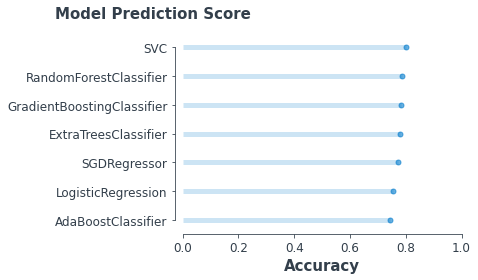

In [270]:
# set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# create some fake data
percentages = pd.Series(y, 
                        index=x)
df = pd.DataFrame({'percentage' : percentages})
df = df.sort_values(by='percentage')

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Accuracy', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'Model Prediction Score', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0,1)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('hist2.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Feature Importance Score')

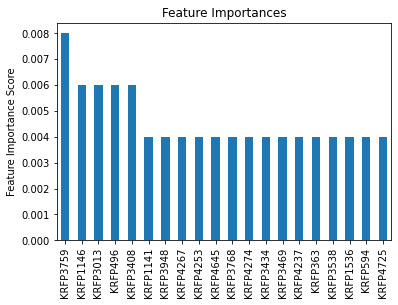

In [197]:


feat_imp[:20]
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Text(0, 0.5, 'Feature Importance Score')

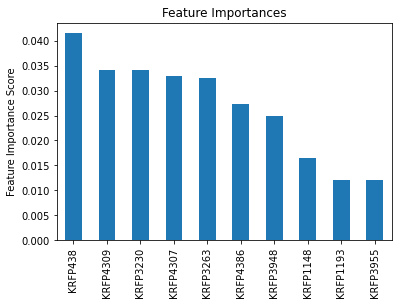

In [19]:
# metrics.accuracy_score(y_test, rnd_forest.predict(X_test))
predictors = [x for x in X.columns]
feat_imp = pd.Series(rnd_forest.feature_importances_, predictors).sort_values(ascending=False)
# feat_imp[:10]
feat_imp[:10].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [63]:
rnd_forest = AdaBoostClassifier(n_estimators=500, learning_rate=1.0)
rnd_forest.fit(X_train, y_train)
np.sum(rnd_forest.predict(X_test) == y_test) / len(y_test)

0.7437705688763516

In [45]:
l = LogisticRegression(max_iter=1000, C=10.0)
l.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000)

In [46]:
np.sum(l.predict(X_test) == y_test) / len(y_test)

0.7527033380347908

In [47]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)

SVC()

In [48]:
np.sum(svm.predict(X_test) == y_test) / len(y_test)

0.7743300423131171

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001], 'kernel': ['rbf']}
base_estimator = SVC()

sh = GridSearchCV(base_estimator, param_grid, cv=2).fit(X, y)
sh.best_estimator_

SVC(C=10, gamma=0.001)

In [ ]:
sh.best_estimator_.fit(X_train, y_train)
np.sum(sh.best_estimator_.predict(X_test) == y_test) / len(y_test)

0.7457690861226025

**Neural Networks**

In [61]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers

In [283]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(len(X_train.columns),)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                33632     
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 34,177
Trainable params: 34,177
Non-trainable params: 0
_________________________________________________________________


In [284]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [75]:
from keras.wrappers.scikit_learn import KerasClassifier


def create_model(optimizer='adam'):
  model = Sequential([
    Dense(32, activation='relu', input_shape=(len(X_train.columns),)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')])
  model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])
  return model

early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                                mode='max',
                                                patience=10,
                                                restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=1)
# optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizers = ['Adam']
batch_size = [10]
param_grid = {
    "batch_size": batch_size, 
    "callbacks": [early_stopping], 
    "epochs": [50],
    "optimizer": optimizers}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


KeyboardInterrupt: ignored

In [ ]:
grid_result.to_csv(results_path.joinpath(f"KlekFP_NN_1.csv"), encoding='utf-8', header=True)

In [106]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.761636 using {'batch_size': 50, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7faf3b717c50>, 'epochs': 50}
0.761636 (0.008081) with: {'batch_size': 50, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7faf3b717c50>, 'epochs': 50}


In [285]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                mode='max',
                                                patience=10,
                                                restore_best_weights=True)

In [287]:
history = model.fit(X_train, y_train, 
  epochs=50, 
  batch_size=16,
  callbacks=[early_stopping],
  validation_split=0.2,
  shuffle=True)

Epoch 1/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2931 - accuracy: 0.8723 - val_loss: 0.5412 - val_accuracy: 0.7744
Epoch 2/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2702 - accuracy: 0.8854 - val_loss: 0.5567 - val_accuracy: 0.7709
Epoch 3/50
426/426 [==============================] - 2s 4ms/step - loss: 0.2520 - accuracy: 0.8900 - val_loss: 0.5683 - val_accuracy: 0.7726
Epoch 4/50
426/426 [==============================] - 2s 6ms/step - loss: 0.2317 - accuracy: 0.9051 - val_loss: 0.6069 - val_accuracy: 0.7685
Epoch 5/50
426/426 [==============================] - 1s 3ms/step - loss: 0.2177 - accuracy: 0.9118 - val_loss: 0.6160 - val_accuracy: 0.7803
Epoch 6/50
426/426 [==============================] - 1s 2ms/step - loss: 0.2022 - accuracy: 0.9142 - val_loss: 0.6512 - val_accuracy: 0.7803
Epoch 7/50
426/426 [==============================] - 1s 2ms/step - loss: 0.1962 - accuracy: 0.9182 - val_loss: 0.6762 - val_accuracy: 0.7714
Epoch 

In [66]:
model.evaluate(X_test, y_test)

67/67 [==============================] - 0s 1ms/step - loss: 0.7821 - accuracy: 0.7762


[0.782127320766449, 0.776210606098175]

In [271]:
from keras.layers import Dropout, BatchNormalization
model = Sequential([
    Dense(32, activation='relu', input_shape=(len(X_train.columns),)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                mode='max',
                                                patience=10,
                                                restore_best_weights=True)

In [273]:
history = model.fit(X_train, y_train, 
  epochs=50, 
  batch_size=16,
  callbacks=[early_stopping],
  validation_split=0.2,
  shuffle=True)

Epoch 1/50
426/426 [==============================] - 2s 4ms/step - loss: 0.5879 - accuracy: 0.6939 - val_loss: 0.5443 - val_accuracy: 0.7297
Epoch 2/50
426/426 [==============================] - 2s 4ms/step - loss: 0.5761 - accuracy: 0.7038 - val_loss: 0.5427 - val_accuracy: 0.7315
Epoch 3/50
426/426 [==============================] - 2s 5ms/step - loss: 0.5623 - accuracy: 0.7150 - val_loss: 0.5365 - val_accuracy: 0.7303
Epoch 4/50
426/426 [==============================] - 2s 5ms/step - loss: 0.5571 - accuracy: 0.7255 - val_loss: 0.5288 - val_accuracy: 0.7286
Epoch 5/50
426/426 [==============================] - 2s 5ms/step - loss: 0.5597 - accuracy: 0.7204 - val_loss: 0.5356 - val_accuracy: 0.7350
Epoch 6/50
426/426 [==============================] - 2s 5ms/step - loss: 0.5477 - accuracy: 0.7297 - val_loss: 0.5253 - val_accuracy: 0.7450
Epoch 7/50
426/426 [==============================] - 1s 3ms/step - loss: 0.5478 - accuracy: 0.7264 - val_loss: 0.5371 - val_accuracy: 0.7239
Epoch 

In [288]:
model.evaluate(X_test, y_test)

67/67 [==============================] - 0s 2ms/step - loss: 0.6311 - accuracy: 0.7612


[0.6310732364654541, 0.761165976524353]

In [280]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

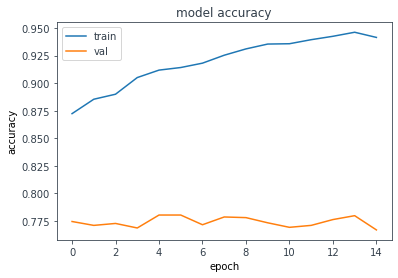

In [289]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()